# Rank reversals

This tutorial provides an overview of the use of the scikit-criteria ranking comparison tools.

## Context and motivation

Multi-criteria decision methods may present irregularities in their rankings that compromise the reliability of their results.
Depending on how the alternatives are defined and evaluated in a problem, rank reversals are classified in five types.
To evaluate the robustness of these methods, Wang & Triantaphyllou (2006) proposed three test criteria that cover all five kinds of rank reversals.

1. **Rank invariance**: The rank of an optimal alternative must remain invariant when a sub-optimal alternative is worsened.
2. **Transitivity**: when a decision problem is partitioned in smaller sub-problems, the relative transitivity of alternatives must be retained.
2. **Recomposition consistency**: a new ranking constructed from a set of smaller sub-problems must be equivalent to the ranking obtained from running the original method.

## Rank reversal checking in scikit-criteria

In scikit-criteria we implement rank reversal checking via the classes `RankInvariantChecker` and `TransitivityChecker`, which are available in the `skcriteria.ranksrev` module. Rank reversal checkers take an MCDM as a parameter, along with other relevant information, and implement an `evaluate()` method against a specific decision matrix.

In the following sections we'll review the usage of each checker to verify the validity of some example MCDMs.

## Test criterion 1 - Rank Invariance

Test criterion 1 evaluates the stability of an MCDM method's top-ranked alternative under minor degradations of non-optimal alternatives, which roughly attempts to detect rank reversals due to irrelevant changes.

In its most basic form, the `RankInvariantChecker` works by worsening each sub-optimal alternative by a chosen amount `repeat` times, and stores every result in a `RanksComparator`.

### Example

We will apply this test to the Van 2021 Evaluation dataset, which ranks cryptocurrencies using a sliding window of 7 days.

In [1]:
import skcriteria as skc
from skcriteria.pipeline import mkpipe
from skcriteria.preprocessing.scalers import SumScaler, VectorScaler
from skcriteria.preprocessing.invert_objectives import InvertMinimize
from skcriteria.agg.similarity import TOPSIS
from skcriteria.ranksrev import RankInvariantChecker

In [2]:
# Load Van 2021 Evaluation Dataset of cryptocurrencies
dm = skc.datasets.load_van2021evaluation(windows_size=7)

# Create the MCDA pipeline
dmaker = mkpipe(
    InvertMinimize(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    TOPSIS()
)

original_result = dmaker.evaluate(dm)
display(original_result)

Alternatives,ADA,BNB,BTC,DOGE,ETH,LINK,LTC,XLM,XRP
Rank,8,2,1,5,4,6,7,3,9


Now we wrap our MCDA method with the `RankInvariantChecker`, which will:
- Apply small degradations to each suboptimal alternative,
- Recompute the ranking each time,
- Collect and compare all rankings.

We'll repeat the mutation twice per alternative.

In [248]:
# Create the stability evaluator
rrt1 = RankInvariantChecker(
    dmaker=dmaker,
    repeat=2,
    allow_missing_alternatives=True
)

# Execute the RRT1 test
comparison = rrt1.evaluate(dm)

We can plot a boxplot of the ranks received by each alternative across all RRT1 mutations.  
This allows us to observe:
- How stable each alternative's position is,
- Whether the top-ranked option remains consistent,
- How sensitive each alternative is to perturbations.

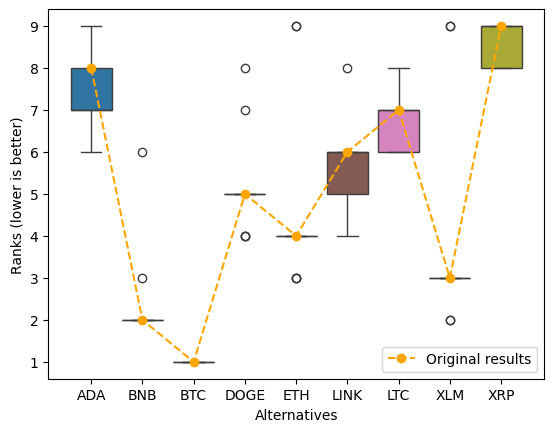

In [249]:
import matplotlib.pyplot as plt

comparison.plot()
plt.plot(
    original_result,
    marker="o",
    linestyle="--",
    color="orange",
    label="Original results",
    zorder=3,
)
plt.legend()
plt.show()

## Test criterions 2 & 3 - Transitivity and Recomposition Consistency

Test criterions 2 and 3 are closely connected in their goal of evaluating the internal consistency and robustness MCDMs via problem decomposition.

- **Test Criterion 2 (Transitivity):**  Ensures that transitivity holds across pairwise comparisons that is, if alternative $A_1 \succ A_2$, and $A_2 \succ A_3$, then $A_1 \succ A_3$.
- **Test Criterion 3 (Recomposition Consistency):** Builds a total ordering from pairwise relationships to recompose them into a complete global ranking for comparison against the original ranking.

Because of this similarity, we opted to unify both criteria into a single class `TransitivityChecker`, that runs both tests secuentially and yields all the relevant details about the test criterions that were encountered in the process.

### Example failing both test cases

For this example we'll use a dataset proposed by Poh & Ang (1999) in search of alternative fuels for land transportation in Singapore.

In [3]:
import skcriteria as skc
from skcriteria.pipeline import mkpipe
from skcriteria.preprocessing.scalers import SumScaler, VectorScaler
from skcriteria.preprocessing.invert_objectives import InvertMinimize
from skcriteria.preprocessing.filters import FilterNonDominated
from skcriteria.agg.similarity import TOPSIS
from skcriteria.ranksrev.rank_transitivity_check import RankTransitivityChecker

In [4]:
# Create a decision matrix
dm = skc.mkdm(
    matrix=[
        [4.57, 4.64, 62.2, 43.8, 8.49, 65.7],
        [65.7, 67.3, 6.03, 43.8, 4.25, 9.42],
        [20.3, 14.0, 20.2, 6.25, 58.3, 20.3],
        [9.42, 14.0, 11.5, 6.25, 29.0, 4.57],
    ],
    objectives=[max, max, max, max, max, max],
    alternatives=["status quo", "oil & ev", "oil & ngv", "methanol"],
    criteria=["supply", "emission", "tech", "safety", "cost", "consumer preference"],
)

To pick our best choice, we'll use a TOPSIS based method and print the resulting ranking.

In [5]:
# Define TOPSIS pipeline
dmaker = mkpipe(
    SumScaler(target="weights"), 
    VectorScaler(target="matrix"), 
    TOPSIS()
)

# Get original ranking
original_result = dmaker.evaluate(dm)
display(original_result)

Alternatives,status quo,oil & ev,oil & ngv,methanol
Rank,2,1,3,4


To verify that we made the right choice picking TOPSIS, we'll be using the `TransitivityChecker`.
As we stated before, for this we'll need our original pipeline, but we also add two extra parameters:

* `allow_missing_alternatives`: desicion maker pipelines can sometimes return rankings with fewer alternatives than the original ones (using a pipeline that implements a filter, for example), which could cause issues in some partitions. This parameter allows for missing alternatives in a ranking to be added with a value of the maximum value of the ranking obtained + 1.

* `max_ranks`: limits the amount of rankings that can be constructed during the recomposition phase.

In [6]:
checker = RankTransitivityChecker(
    dmaker,
    allow_missing_alternatives=True,
    max_ranks=10
)

In [10]:
results = checker.evaluate(dm=dm)

print("Transitivity Analysis Results:")
print(f"Test Criterion 2 (Transitivity): {results.e_.test_criterion_2}")
print(f"Test Criterion 3 (Recomposition Consistency): {results.e_.test_criterion_3}")
print(f"Transitivity Break Rate: {results.e_.transitivity_break_rate:.4f}")

Transitivity Analysis Results:
Test Criterion 2 (Transitivity): Not Passed
Test Criterion 3 (Recomposition Consistency): Not Passed
Transitivity Break Rate: 0.5000


The `TransitivityChecker` evaluation provides several key pieces of information:

1. **Test Criterion 2 Result**: Indicates whether the method maintains transitivity across all pairwise comparisons
2. **Test Criterion 3 Result**: Shows whether the recomposed ranking matches the original ranking
3. **Transitivity Break Rate**: A normalized measure of how many transitivity violations exist relative to the theoretical maximum.

Given that our pipeline failed the test, we should be able to see many different rankings of our original desicion matrix.

In [13]:
print("Ranking Comparison:")

items = list(results.named_ranks.items())
for rank_name, ranking in items[:4]:
    print(f"\n{rank_name}:")
    display(ranking)

Ranking Comparison:

Original:


Alternatives,status quo,oil & ev,oil & ngv,methanol
Rank,2,1,3,4



Recomposition1:


Alternatives,status quo,oil & ev,oil & ngv,methanol
Rank,3,1,2,4



Recomposition2:


Alternatives,status quo,oil & ev,oil & ngv,methanol
Rank,1,2,3,4



Recomposition3:


Alternatives,status quo,oil & ev,oil & ngv,methanol
Rank,2,3,1,4


### Example that passes both tests

This example uses a simple stock selection decision matrix and applies a TOPSIS-based MCDA pipeline.
The pipeline includes preprocessing steps such as inverting objectives (for maximization) and filtering non-dominated alternatives.

We then check whether the resulting rankings satisfy the transitivity and recomposition consistency properties, in such case, Both criteria should return True, and the transitivity break rate should be 0, indicating robust decision-making consistency.

In [14]:
# Create a decision matrix for energy alternatives
dm = skc.datasets.load_simple_stock_selection()

# Define TOPSIS pipeline
dmaker = mkpipe(InvertMinimize(), 
                FilterNonDominated(), 
                TOPSIS())

# Get original ranking
original_result = dmaker.evaluate(dm)
display(original_result)

# Create the transitivity checker
checker = RankTransitivityChecker(
    dmaker, 
    allow_missing_alternatives=True, 
    max_ranks=1000
)

# Run the transitivity evaluation
results = checker.evaluate(dm=dm)
display(results['Original'])
display(results['Recomposition1'])

print("\nTransitivity Analysis Results:")
print(f"Test Criterion 2 (Transitivity): {results.extra_['test_criterion_2']}")
print(
    f"Test Criterion 3 (Recomposition Consistency): {results.extra_['test_criterion_3']}"
)
print(
    f"Transitivity Break Rate: {results.extra_['transitivity_break_rate']:.4f}"
)

Alternatives,PE,JN,AA,GN
Rank,3,4,2,1


Alternatives,PE,JN,AA,GN,FX,MM
Rank,3,4,2,1,5,5


Alternatives,PE,JN,AA,GN,FX,MM
Rank,3,4,2,1,5,5



Transitivity Analysis Results:
Test Criterion 2 (Transitivity): Passed
Test Criterion 3 (Recomposition Consistency): Passed
Transitivity Break Rate: 0.0000


The plot below shows the ranking results for each alternative, with confidence intervals indicating the stability of rankings across different evaluation scenarios. The dashed line connects the mean ranks to visualize potential transitivity issues in the decision matrix.

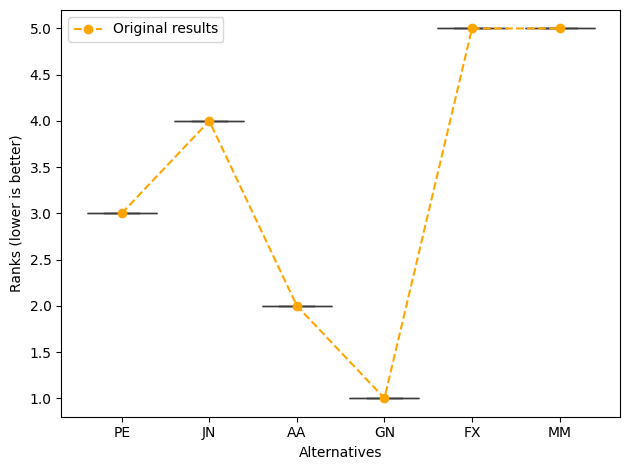

In [23]:
import matplotlib.pyplot as plt

ax = results.plot()
ax.plot(
    results[0],
    marker="o",
    linestyle="--",
    color="orange",
    label="Original results",
    zorder=3,
)
ax.legend()
plt.tight_layout();

### Untying and Recomposition strategies

When transitivity violations are detected in the dominance graph (i.e., cycles), the algorithm applies cycle-breaking strategies to restore consistency and generate valid rankings.

The strategy used is controlled via the `make_transitive_strategy` parameter:
- `random` (default): removes edges uniformly at random from cycles.
- `weighted`: removes edges with higher participation in cycles (based on frequency), prioritizing structurally disruptive edges.
Custom strategies can also be provided as callables: `func(cycle, edge_freq, rng) → edge_tuple`.

Multiple acyclic graphs may be generated depending on the number of cycle-breaking configurations (`max_ranks`), each yielding a potentially different recomposed ranking.

Ties during pairwise evaluation are resolved through dominance analysis: if one alternative dominates the other in more criteria, it's considered superior even if the scores are tied.

To illustrate these strategies in practice, we revisit the decision matrix used in the *Example failing both test cases* section.
We apply the `TransitivityChecker` to the original TOPSIS ranking and generate alternative rankings using two different cycle-breaking strategies: `random` and `weighted`.

This example shows how different strategies for restoring transitivity can affect the final ranking, even when based on the same input data.

In [258]:
# Create a decision matrix
dm = skc.mkdm(
    matrix=[
        [4.57, 4.64, 62.2, 43.8, 8.49, 65.7],
        [65.7, 67.3, 6.03, 43.8, 4.25, 9.42],
        [20.3, 14.0, 20.2, 6.25, 58.3, 20.3],
        [9.42, 14.0, 11.5, 6.25, 29.0, 4.57],
    ],
    objectives=[max, max, max, max, max, max],
    alternatives=["status quo", "oil & ev", "oil & ngv", "methanol"],
    criteria=["supply", "emission", "tech", "safety", "cost", "consumer preference"
    ],
)

# Define TOPSIS pipeline
dmaker = mkpipe(
    SumScaler(target="weights"), VectorScaler(target="matrix"), TOPSIS()
)
original_result = dmaker.evaluate(dm)

In [259]:
# Recomposition using different cycle-breaking strategies

# Use the default strategy (random)
checker_random = RankTransitivityChecker(
    dmaker,
    make_transitive_strategy="random",
    max_ranks=1
)
res_random = checker_random.evaluate(dm=dm)

# Use the 'weighted' strategy
checker_weighted = RankTransitivityChecker(
    dmaker,
    make_transitive_strategy="weighted",
    max_ranks=1
)
res_weighted = checker_weighted.evaluate(dm=dm)

# Access recomposed rankings
rrandom = res_random["Recomposition1"]
rweighted = res_weighted["Recomposition1"]

display(original_result, rrandom, rweighted)

Alternatives,status quo,oil & ev,oil & ngv,methanol
Rank,2,1,3,4


Alternatives,status quo,oil & ev,oil & ngv,methanol
Rank,1,2,3,4


Alternatives,status quo,oil & ev,oil & ngv,methanol
Rank,3,1,2,4


## References

- Wang & Triantaphyllou (2006). Ranking Irregularities When Evaluating Alternatives by Using Some Multi- Criteria Decision Analysis Methods.
- Poh & Ang (1999). Transportation fuels and policy for Singapore: an AHP planning approach.